<a href="https://colab.research.google.com/github/SkinHeadDressSom/Ultimate-X-ray-AI/blob/main/CXR_data_collection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -q kaggle

In [2]:
import os
from google.colab import files

In [3]:
os.makedirs("~/.kaggle", exist_ok=True)
kaggle_json_path = "~/.kaggle/kaggle.json"

uploaded = files.upload()

Saving kaggle.json to kaggle.json


In [4]:
 !mkdir ~/.kaggle
 !cp kaggle.json ~/.kaggle/
 !chmod 600 ~/.kaggle/kaggle.json

## NIH

### Download NIH dataset

In [ ]:
!kaggle datasets download nih-chest-xrays/data

Dataset URL: https://www.kaggle.com/datasets/nih-chest-xrays/data
License(s): CC0-1.0
100% 42.0G/42.0G [24:43<00:00, 39.6MB/s]
100% 42.0G/42.0G [24:43<00:00, 30.4MB/s]


In [ ]:
!mkdir nih-chest-xrays
!unzip data.zip -d nih-chest-xrays

Streaming output truncated to the last 5000 lines.
  inflating: nih-chest-xrays/images_012/images/00028897_016.png  
  inflating: nih-chest-xrays/images_012/images/00028897_017.png  
  inflating: nih-chest-xrays/images_012/images/00028897_018.png  
  inflating: nih-chest-xrays/images_012/images/00028897_019.png  
  inflating: nih-chest-xrays/images_012/images/00028897_020.png  
  inflating: nih-chest-xrays/images_012/images/00028898_000.png  
  inflating: nih-chest-xrays/images_012/images/00028899_000.png  
  inflating: nih-chest-xrays/images_012/images/00028899_001.png  
  inflating: nih-chest-xrays/images_012/images/00028899_002.png  
  inflating: nih-chest-xrays/images_012/images/00028900_000.png  
  inflating: nih-chest-xrays/images_012/images/00028901_000.png  
  inflating: nih-chest-xrays/images_012/images/00028901_001.png  
  inflating: nih-chest-xrays/images_012/images/00028902_000.png  
  inflating: nih-chest-xrays/images_012/images/00028902_001.png  
  inflating: nih-chest-xr

### filtered bbox

In [ ]:
import pandas as pd
import os
import shutil
import matplotlib.pyplot as plt
import cv2

In [ ]:
metadata_path = "/content/nih-chest-xrays/Data_Entry_2017.csv"
metadata = pd.read_csv(metadata_path)
metadata.head()

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11
0,00000001_000.png,Cardiomegaly,0,1,58,M,PA,2682,2749,0.143,0.143,NaN
1,00000001_001.png,Cardiomegaly|Emphysema,1,1,58,M,PA,2894,2729,0.143,0.143,NaN
2,00000001_002.png,Cardiomegaly|Effusion,2,1,58,M,PA,2500,2048,0.168,0.168,NaN
3,00000002_000.png,No Finding,0,2,81,M,PA,2500,2048,0.171,0.171,NaN
4,00000003_000.png,Hernia,0,3,81,F,PA,2582,2991,0.143,0.143,NaN


In [ ]:
image_base_dir = "/content/nih-chest-xrays/"

def get_all_image_paths(base_dir):
    image_paths = []
    for subdir, _, files in os.walk(base_dir):
        for file in files:
            if file.endswith('.png') or file.endswith('.jpg'):
                image_paths.append(os.path.join(subdir, file))
    return image_paths

image_paths = get_all_image_paths(image_base_dir)

print(f"Found {len(image_paths)} images.")
print(image_paths[:5])

Found 112120 images.
['/content/nih-chest-xrays/images_011/images/00025910_000.png', '/content/nih-chest-xrays/images_011/images/00027294_002.png', '/content/nih-chest-xrays/images_011/images/00026144_001.png', '/content/nih-chest-xrays/images_011/images/00027649_000.png', '/content/nih-chest-xrays/images_011/images/00025081_013.png']


In [ ]:
image_path_dict = {os.path.basename(path): path for path in image_paths}
no_finding_df = metadata[metadata["Finding Labels"] == "No Finding"]
no_finding_df = no_finding_df.dropna(axis=1, how='all')
no_finding_df['Image Path'] = no_finding_df['Image Index'].map(image_path_dict)
no_finding_df = no_finding_df.drop(columns=['Follow-up #', 'Patient ID', 'Patient Age', 'Patient Gender', 'View Position', 'OriginalImage[Width', 'Height]', 'OriginalImagePixelSpacing[x', 'y]'])
no_finding_df = no_finding_df.rename(columns={'Finding Labels': 'Finding Label'})
no_finding_df.head()

,Image Index,Finding Label,Image Path
3,00000002_000.png,No Finding,/content/nih-chest-xrays/images_001/images/000...
13,00000005_000.png,No Finding,/content/nih-chest-xrays/images_001/images/000...
14,00000005_001.png,No Finding,/content/nih-chest-xrays/images_001/images/000...
15,00000005_002.png,No Finding,/content/nih-chest-xrays/images_001/images/000...
16,00000005_003.png,No Finding,/content/nih-chest-xrays/images_001/images/000...


In [ ]:
bbox_path = "/content/nih-chest-xrays/BBox_List_2017.csv"
bbox_df = pd.read_csv(bbox_path)

image_path_dict = {os.path.basename(path): path for path in image_paths}
bbox_df['Image Path'] = bbox_df['Image Index'].map(image_path_dict)
bbox_df = bbox_df.dropna(axis=1, how='all')
bbox_df.head()

,Image Index,Finding Label,Bbox [x,y,w,h],Image Path
0,00013118_008.png,Atelectasis,225.084746,547.019217,86.779661,79.186441,/content/nih-chest-xrays/images_006/images/000...
1,00014716_007.png,Atelectasis,686.101695,131.543498,185.491525,313.491525,/content/nih-chest-xrays/images_007/images/000...
2,00029817_009.png,Atelectasis,221.830508,317.053115,155.118644,216.949153,/content/nih-chest-xrays/images_012/images/000...
3,00014687_001.png,Atelectasis,726.237288,494.951420,141.016949,55.322034,/content/nih-chest-xrays/images_007/images/000...
4,00017877_001.png,Atelectasis,660.067797,569.780787,200.677966,78.101695,/content/nih-chest-xrays/images_008/images/000...


In [ ]:
merged_df = pd.merge(no_finding_df, bbox_df, how='outer')
merged_df

,Image Index,Finding Label,Image Path,Bbox [x,y,w,h]
0,00000002_000.png,No Finding,/content/nih-chest-xrays/images_001/images/000...,NaN,NaN,NaN,NaN
1,00000005_000.png,No Finding,/content/nih-chest-xrays/images_001/images/000...,NaN,NaN,NaN,NaN
2,00000005_001.png,No Finding,/content/nih-chest-xrays/images_001/images/000...,NaN,NaN,NaN,NaN
3,00000005_002.png,No Finding,/content/nih-chest-xrays/images_001/images/000...,NaN,NaN,NaN,NaN
4,00000005_003.png,No Finding,/content/nih-chest-xrays/images_001/images/000...,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...
61340,00030801_000.png,No Finding,/content/nih-chest-xrays/images_012/images/000...,NaN,NaN,NaN,NaN
61341,00030802_000.png,No Finding,/content/nih-chest-xrays/images_012/images/000...,NaN,NaN,NaN,NaN
61342,00030803_000.png,No Finding,/content/nih-chest-xrays/images_012/images/000...,NaN,NaN,NaN,NaN
61343,00030804_000.png,No Finding,/content/nih-chest-xrays/images_012/images/000...,NaN,NaN,NaN,NaN


In [ ]:
merged_df.to_csv('/content/drive/MyDrive/NIH/bbox_nih.csv', index=False)

In [ ]:
destination_dir = '/content/drive/MyDrive/NIH/train'

if 'Image Path' in merged_df.columns:
    for index, row in merged_df.iterrows():
        source_path = row['Image Path']
        if os.path.exists(source_path):
            try:
                shutil.copy(source_path, destination_dir)
                print(f"Copied: {source_path} to {destination_dir}")
            except Exception as e:
                print(f"Error copying {source_path}: {e}")
        else:
            print(f"File does not exist: {source_path}")
else:
    print("Column 'file_path' not found in the CSV file.")

Streaming output truncated to the last 5000 lines.
Copied: /content/nih-chest-xrays/images_011/images/00027355_002.png to /content/drive/MyDrive/NIH/train
Copied: /content/nih-chest-xrays/images_011/images/00027355_004.png to /content/drive/MyDrive/NIH/train
Copied: /content/nih-chest-xrays/images_011/images/00027355_007.png to /content/drive/MyDrive/NIH/train
Copied: /content/nih-chest-xrays/images_011/images/00027355_010.png to /content/drive/MyDrive/NIH/train
Copied: /content/nih-chest-xrays/images_011/images/00027355_012.png to /content/drive/MyDrive/NIH/train
Copied: /content/nih-chest-xrays/images_011/images/00027355_013.png to /content/drive/MyDrive/NIH/train
Copied: /content/nih-chest-xrays/images_011/images/00027355_015.png to /content/drive/MyDrive/NIH/train
Copied: /content/nih-chest-xrays/images_011/images/00027355_016.png to /content/drive/MyDrive/NIH/train
Copied: /content/nih-chest-xrays/images_011/images/00027357_006.png to /content/drive/MyDrive/NIH/train
Copied: /cont

In [ ]:
len(os.listdir(destination_dir))

61241

In [ ]:
print(f"Unique findings: {merged_df['Finding Label'].unique()}")

Unique findings: ['No Finding' 'Infiltrate' 'Atelectasis' 'Pneumonia' 'Cardiomegaly'
 'Effusion' 'Pneumothorax' 'Mass' 'Nodule']


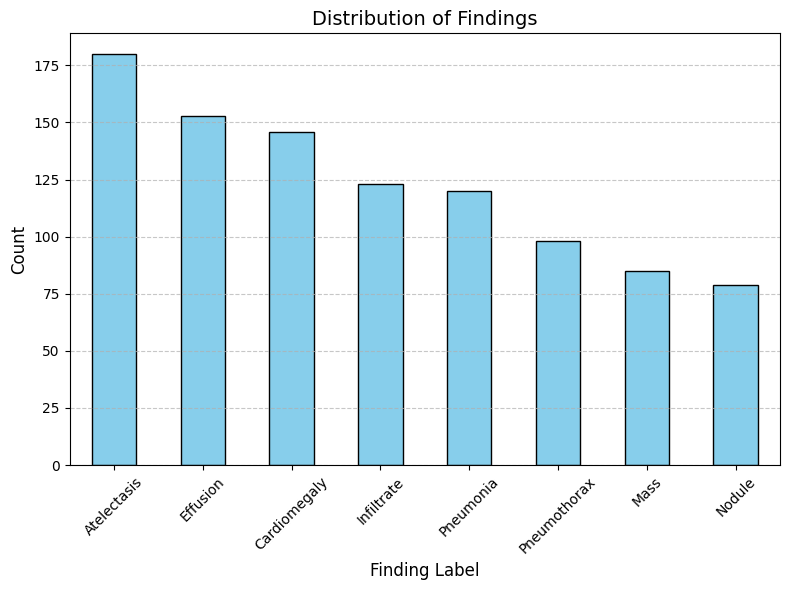

In [ ]:
finding_counts = bbox_df["Finding Label"].value_counts()

plt.figure(figsize=(8, 6))
finding_counts.plot(kind="bar", color="skyblue", edgecolor="black")
plt.title("Distribution of Findings", fontsize=14)
plt.xlabel("Finding Label", fontsize=12)
plt.ylabel("Count", fontsize=12)
plt.xticks(rotation=45, fontsize=10)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()

plt.show()

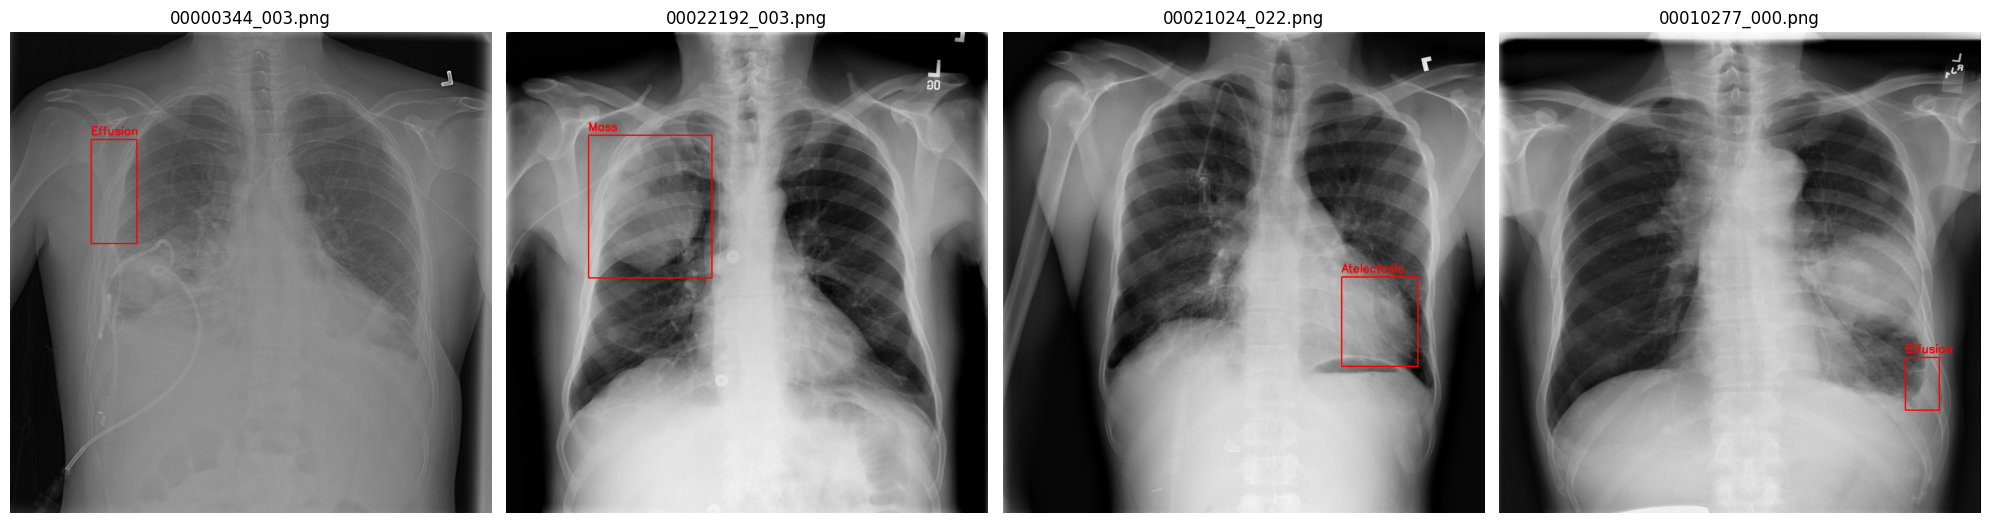

In [ ]:
selected_annotations = bbox_df.sample(4)

fig, axes = plt.subplots(1, 4, figsize=(20, 8))
axes = axes.flatten()

for i, (_, row) in enumerate(selected_annotations.iterrows()):
    image_path = row["Image Path"]

    image = cv2.imread(image_path)
    if image is None:
        print(f"Image {row['Image Path']} not found. Skipping...")
        continue

    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    x_min, y_min = int(row['Bbox [x']), int(row['y'])
    x_max, y_max = x_min + int(row['w']), y_min + int(row['h]'])
    label = row['Finding Label']
    cv2.rectangle(image, (x_min, y_min), (x_max, y_max), (255, 0, 0), 2)
    cv2.putText(image, label, (x_min, y_min - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.8, (255, 0, 0), 2)

    axes[i].imshow(image)
    axes[i].set_title(row['Image Index'])
    axes[i].axis('off')

plt.tight_layout()
plt.show()

## VinBigData

In [ ]:
!kaggle competitions download -c vinbigdata-chest-xray-abnormalities-detection -p /content/drive/MyDrive/VinBigData/

100% 142G/142G [26:37<00:00, 157MB/s]
100% 142G/142G [26:37<00:00, 95.1MB/s]


In [ ]:
import zipfile

zip_file_path = '/content/drive/MyDrive/VinBigData/vinbigdata-chest-xray-abnormalities-detection.zip'

train_directory = 'train/'

with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    for file in zip_ref.namelist():
        if file.startswith(train_directory):
            zip_ref.extract(file, '/content/drive/MyDrive/VinBigData/')

In [ ]:
len(os.listdir('/content/drive/MyDrive/VinBigData/train'))

15000

## RSNA

In [5]:
!kaggle competitions download -c rsna-pneumonia-detection-challenge

100% 3.66G/3.66G [02:56<00:00, 20.2MB/s]
100% 3.66G/3.66G [02:56<00:00, 22.3MB/s]


In [6]:
!mkdir rsna-pneumonia-detection-challenge
!unzip rsna-pneumonia-detection-challenge.zip -d rsna-pneumonia-detection-challenge

Streaming output truncated to the last 5000 lines.
  inflating: rsna-pneumonia-detection-challenge/stage_2_train_images/d5231546-354e-4071-9af1-6644beabfd86.dcm  
  inflating: rsna-pneumonia-detection-challenge/stage_2_train_images/d5252a78-3ea1-48e9-9ffb-e7535be3ce80.dcm  
  inflating: rsna-pneumonia-detection-challenge/stage_2_train_images/d525eafb-8908-45fd-a942-48d07c435487.dcm  
  inflating: rsna-pneumonia-detection-challenge/stage_2_train_images/d5265640-17db-4880-866d-d2952e32941c.dcm  
  inflating: rsna-pneumonia-detection-challenge/stage_2_train_images/d5277276-f8f8-40e9-b8e1-791cf5d96ac0.dcm  
  inflating: rsna-pneumonia-detection-challenge/stage_2_train_images/d528d9e9-647a-4e2e-a16c-bd5e32a5bbf5.dcm  
  inflating: rsna-pneumonia-detection-challenge/stage_2_train_images/d5293a3e-f050-4b98-8bbf-1f40e25bced5.dcm  
  inflating: rsna-pneumonia-detection-challenge/stage_2_train_images/d52cbb5a-1d0a-457d-8c72-0f7aeec21ca7.dcm  
  inflating: rsna-pneumonia-detection-challenge/stage

In [19]:
import pandas as pd
import os
import shutil

In [15]:
df = pd.read_csv('/content/rsna-pneumonia-detection-challenge/stage_2_train_labels.csv')
df = df[df['Target'] == 1]
df

,patientId,x,y,width,height,Target
4,00436515-870c-4b36-a041-de91049b9ab4,264.0,152.0,213.0,379.0,1
5,00436515-870c-4b36-a041-de91049b9ab4,562.0,152.0,256.0,453.0,1
8,00704310-78a8-4b38-8475-49f4573b2dbb,323.0,577.0,160.0,104.0,1
9,00704310-78a8-4b38-8475-49f4573b2dbb,695.0,575.0,162.0,137.0,1
14,00aecb01-a116-45a2-956c-08d2fa55433f,288.0,322.0,94.0,135.0,1
...,...,...,...,...,...,...
30220,c1e73a4e-7afe-4ec5-8af6-ce8315d7a2f2,316.0,504.0,179.0,273.0,1
30221,c1ec14ff-f6d7-4b38-b0cb-fe07041cbdc8,609.0,464.0,240.0,284.0,1
30222,c1ec14ff-f6d7-4b38-b0cb-fe07041cbdc8,185.0,298.0,228.0,379.0,1
30225,c1f7889a-9ea9-4acb-b64c-b737c929599a,570.0,393.0,261.0,345.0,1


In [18]:
df.to_csv('/content/drive/MyDrive/RSNA//rsna_train_labels.csv', index=False)

In [16]:
len(os.listdir('/content/rsna-pneumonia-detection-challenge/stage_2_train_images'))

26684

In [23]:
os.listdir('/content/rsna-pneumonia-detection-challenge/stage_2_train_images')[:5]

['e128a2e8-6f9f-4615-8752-4be9eb2eaa14.dcm',
 'd5c0eb30-b101-4bcc-a8c0-f08675b45efa.dcm',
 '2f0e9e81-07d0-4fd3-903d-6223c2cfb1bb.dcm',
 '4dbc6799-0777-4982-b20d-094b070218c2.dcm',
 '68276cbf-0a10-439b-905a-6cefb1e2fdf3.dcm']

In [20]:
source_dir = "/content/rsna-pneumonia-detection-challenge/stage_2_train_images"
target_dir = "/content/drive/MyDrive/RSNA/train"

for patient_id in df['patientId']:
    file_name = f"{patient_id}.dcm"
    source_path = os.path.join(source_dir, file_name)
    target_path = os.path.join(target_dir, file_name)

    if os.path.exists(source_path):
        shutil.copy(source_path, target_path)
        print(f"Copied: {file_name}")
    else:
        print(f"File not found: {file_name}")

Streaming output truncated to the last 5000 lines.
Copied: 8fb744d3-d002-4b00-ab8c-fe96d252e1e5.dcm
Copied: 8fcccb09-858d-4e00-9d3d-09f499477fcd.dcm
Copied: 8fcccb09-858d-4e00-9d3d-09f499477fcd.dcm
Copied: 8fdda05d-cfd6-4a9f-bc0e-cd4f542a8c0d.dcm
Copied: 8fdda05d-cfd6-4a9f-bc0e-cd4f542a8c0d.dcm
Copied: 8fde7f84-5ddc-4b0d-9eb6-3daa4fcad8af.dcm
Copied: 8fe8e95c-46a1-4ee2-a2d6-2174c6ec50cf.dcm
Copied: 8fe8e95c-46a1-4ee2-a2d6-2174c6ec50cf.dcm
Copied: 8feb2bb2-88e0-4796-b5c5-005159a8d8d0.dcm
Copied: 8feb2bb2-88e0-4796-b5c5-005159a8d8d0.dcm
Copied: 8fefb690-a1b7-4948-98a6-088e5dd8b3da.dcm
Copied: 90035195-09b5-4fc6-8cbc-f16bb0c26048.dcm
Copied: 9012a0fd-7354-4934-8a18-de81af9a153a.dcm
Copied: 9012a0fd-7354-4934-8a18-de81af9a153a.dcm
Copied: 9038b827-4244-4154-bcf3-2d14c486bf54.dcm
Copied: 9038b827-4244-4154-bcf3-2d14c486bf54.dcm
Copied: 9039dfee-f9b1-45ee-a487-ab6a51d7cfe0.dcm
Copied: 904070bc-c210-47ef-b886-abb6b0dd7ee3.dcm
Copied: 904070bc-c210-47ef-b886-abb6b0dd7ee3.dcm
Copied: 9042bce5-f

In [21]:
len(os.listdir('/content/drive/MyDrive/RSNA/train'))

6012

## Covid19

In [ ]:
# !kaggle datasets download tawsifurrahman/covid19-radiography-database

In [ ]:
# !mkdir covid19-radiography-database
# !unzip covid19-radiography-database.zip -d covid19-radiography-database